# Setup Model

In [1]:
from langchain_aws import ChatBedrock
from langchain_aws import BedrockEmbeddings, AmazonKnowledgeBasesRetriever
import boto3

session = boto3.Session(profile_name="default")
bedrock_client = session.client('bedrock-runtime')

model_id = 'anthropic.claude-3-haiku-20240307-v1:0'
# model_id = 'anthropic.claude-3-5-sonnet-20240620-v1:0'
model_kwargs =  { 
        "max_tokens": 512,
        "temperature": 0,
        "top_p": 1,
}

# LangChain class for chat
model = ChatBedrock(
    client=bedrock_client,
    model_id=model_id,
    model_kwargs=model_kwargs,
)

# Using agents as Graph nodes

In [2]:
#Reuse the agents created in the previous chapters by importing their notebooks
#This will also import the chatbot and execute the code available.
#Ignore / hide the code output and use only the agents

#import the Product QnA Agent
%run "2_product_qna_agentic_chatbot.ipynb" 
print("===============================================================")
#import the orders agents
%run "3_orders_chatbot_with_custom_agent.ipynb"

            Name  Price  ShippingDays
0  AlphaBook Pro   1499             2
1     GammaAir X   1399             7
2  SpectraBook S   2499             7
3   OmegaPro G17   2199            14
4  NanoEdge Flex   1699             2
1399


/tmp/ipykernel_76197/3294583023.py:30: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print(get_laptop_price("GammaAir"))


================================ Human Message =================================

What are the features for GammaAir?
================================== Ai Message ==================================

Okay, let me look up the features for the GammaAir laptop using the available tools.
Tool Calls:
  Get_Product_Features (toolu_bdrk_01TwriFPeYSpc8hyH8nVujXC)
 Call ID: toolu_bdrk_01TwriFPeYSpc8hyH8nVujXC
  Args:
    query: GammaAir
================================= Tool Message =================================
Name: Get_Product_Features

Fictional Laptop Descriptions
AlphaBook Pro
The AlphaBook Pro is a sleek ultrabook with a 12th Gen Intel i7 processor, 16GB of DDR4 RAM,
and a fast 1TB SSD. Ideal for professionals on the go, this laptop offers an impressive blend of
power and portability.
GammaAir X
GammaAir X combines an AMD Ryzen 7 processor with 32GB of DDR4 memory and a 512GB
NVMe SSD. Its thin and light form factor makes it perfect for users who need high performance in a
portable d

In [3]:
import functools
# Helper function to invoke an agent
def agent_node(state, agent, name, config):

    #extract thread-id from request for conversation memory
    thread_id=config["metadata"]["thread_id"]
    #Set the config for calling the agent
    agent_config = {"configurable": {"thread_id": thread_id}}

    #Pass the thread-id to establish memory for chatbot
    #Invoke the agent with the state
    result = agent.invoke(state, agent_config)

    # Convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        final_result=AIMessage(result['messages'][-1].content)
    return {
        "messages": [final_result]
    }

#Create the product QnA node
product_QnA_node=functools.partial(agent_node, 
                                   agent=product_QnA_agent, 
                                   name="Product_QnA_Agent")
#Create the Orders node
#For a custom agent, the agent graph need to be provided as input
orders_node=functools.partial(agent_node,
                              agent=orders_agent.agent_graph,
                              name="Orders_Agent")

# Create the Routing Agent & Chatbot

In [4]:
#Creating the routing agent

from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
import operator

class RouterAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class RouterAgent:

    def __init__(self, model, system_prompt, smalltalk_prompt, debug=False):
        
        self.system_prompt=system_prompt
        self.smalltalk_prompt=smalltalk_prompt
        self.model=model
        self.debug=debug
        
        router_graph=StateGraph(RouterAgentState)
        router_graph.add_node("Router",self.call_llm)
        router_graph.add_node("Product_Agent",product_QnA_node)
        router_graph.add_node("Orders_Agent",orders_node)
        router_graph.add_node("Small_Talk", self.respond_smalltalk)
                              
        router_graph.add_conditional_edges(
            "Router",
            self.find_route,
            {"PRODUCT": "Product_Agent", 
             "ORDER" : "Orders_Agent",
             "SMALLTALK" : "Small_Talk",
             "END": END }
        )

        #One way routing, not coming back to router
        router_graph.add_edge("Product_Agent",END)
        router_graph.add_edge("Orders_Agent",END)
        router_graph.add_edge("Small_Talk",END)
        
        #Set where there graph starts
        router_graph.set_entry_point("Router")
        self.router_graph = router_graph.compile()

    def call_llm(self, state:RouterAgentState):
        messages=state["messages"]
        if self.debug:
            print(f"Call LLM received {messages}")
            
        #If system prompt exists, add to messages in the front
        if self.system_prompt:
            messages = [SystemMessage(content=self.system_prompt)] + messages

        #invoke the model with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"Call LLM result {result}")
        return { "messages":[result] }

    def respond_smalltalk(self, state:RouterAgentState):
        messages=state["messages"]
        if self.debug:
            print(f"Small talk received: {messages}")
            
        #If system prompt exists, add to messages in the front
        
        messages = [SystemMessage(content=self.smalltalk_prompt)] + messages

        #invoke the model with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"Small talk result {result}")
        return { "messages":[result] }
        
    def find_route(self, state:RouterAgentState):
        last_message = state["messages"][-1]
        if self.debug: 
            print("Router: Last result from LLM : ", last_message)

        #Set the last message as the destination
        destination=last_message.content

        if self.debug:
            print(f"Destination chosen : {destination}")
        return destination

In [5]:
from IPython.display import Image

#Setup the system problem
system_prompt = """ 
You are a Router, that analyzes the input query and chooses 4 options:
SMALLTALK: If the user input is small talk, like greetings and good byes.
PRODUCT: If the query is a product question about laptops, like features, specifications and pricing.
ORDER: If the query is about orders for laptops, like order status, order details or update order quantity
END: Default, when its neither PRODUCT or ORDER.

The output should only be just one word out of the possible 4 : SMALLTALK, PRODUCT, ORDER, END.
"""

smalltalk_prompt="""
If the user request is small talk, like greetings and goodbyes, respond professionally.
Mention that you will be able to answer questions about laptop product features and provide order status and updates.
"""

router_agent = RouterAgent(model, 
                           system_prompt, 
                           smalltalk_prompt,
                           debug=False)

# Image(router_agent.router_graph.get_graph().draw_mermaid_png())

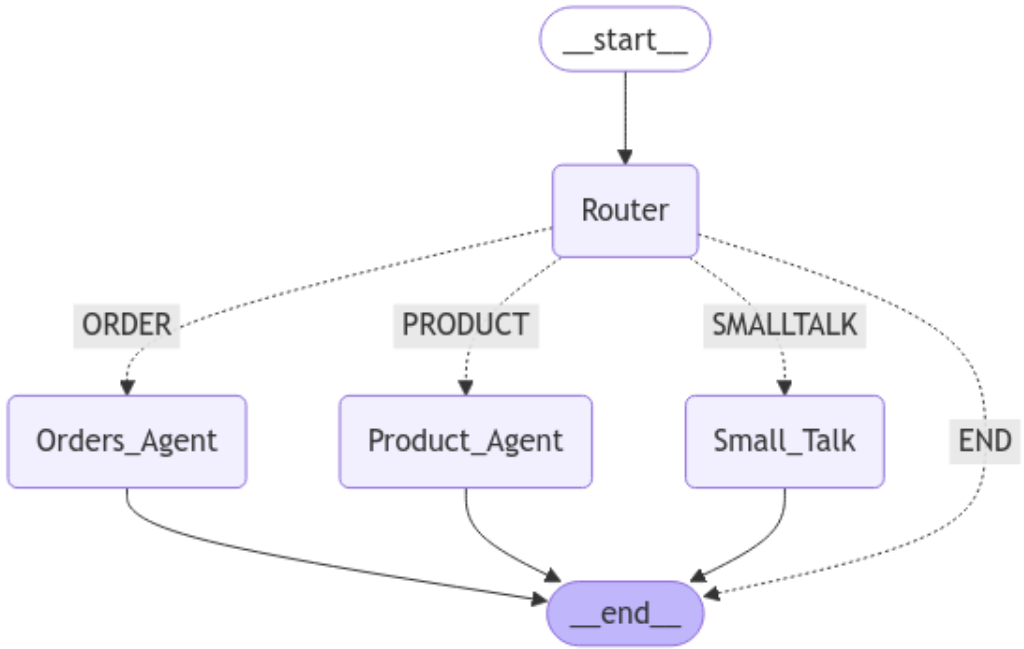

# Execute the Routing chatbot

In [6]:
#Execute a single request
messages=[HumanMessage(content="Tell me about the features of SpectraBook")]
result=router_agent.router_graph.invoke({"messages":messages},config)
for message in result['messages']:
    print(message.pretty_repr())

Error raised by bedrock service
Traceback (most recent call last):
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/langchain_aws/llms/bedrock.py", line 935, in _prepare_input_and_invoke
    response = self.client.invoke_model(**request_options)
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/botocore/client.py", line 570, in _api_call
    return self._make_api_call(operation_name, kwargs)
           ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/botocore/context.py", line 123, in wrapper
    return func(*args, **kwargs)
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/botocore/client.py", line 1031, in _make_api_call
    raise error_class(parsed_response, operation_name)
botocore.errorfactory.ValidationException: An error occurred (ValidationException) when calling the InvokeModel operation: Your API request included an `assistant` 

ValidationException: An error occurred (ValidationException) when calling the InvokeModel operation: Your API request included an `assistant` message in the final position, which would pre-fill the `assistant` response. When using tools, pre-filling the `assistant` response is not supported.

In [7]:
#Execute a single request
messages=[HumanMessage(content="What is the status of order ORD-7311?")]
result=router_agent.router_graph.invoke({"messages":messages},config)
for message in result['messages']:
    print(message.pretty_repr())

Error raised by bedrock service
Traceback (most recent call last):
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/langchain_aws/llms/bedrock.py", line 935, in _prepare_input_and_invoke
    response = self.client.invoke_model(**request_options)
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/botocore/client.py", line 570, in _api_call
    return self._make_api_call(operation_name, kwargs)
           ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/botocore/context.py", line 123, in wrapper
    return func(*args, **kwargs)
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/botocore/client.py", line 1031, in _make_api_call
    raise error_class(parsed_response, operation_name)
botocore.errorfactory.ValidationException: An error occurred (ValidationException) when calling the InvokeModel operation: Your API request included an `assistant` 

ValidationException: An error occurred (ValidationException) when calling the InvokeModel operation: Your API request included an `assistant` message in the final position, which would pre-fill the `assistant` response. When using tools, pre-filling the `assistant` response is not supported.

In [8]:
import uuid
#Send a sequence of messages to chatbot and get its response
#This simulates the conversation between the user and the Agentic chatbot
user_inputs = [
    "How are you doing?",
    "Please show me the details of the order ORD-7311",
    "Can you add one more of that laptop to the order? ",
    "Tell me about the features of SpectraBook laptop",
    "How much does it cost?",
    "Bye"
]

#Create a new thread
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = router_agent.router_graph.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")

----------------------------------------
USER : How are you doing?

AGENT : : Hello! As an AI assistant, I'm doing well and ready to assist you. I'd be happy to answer any questions you have about laptop product features or provide updates on your order status. Please let me know how I can help.
----------------------------------------
USER : Please show me the details of the order ORD-7311


Error raised by bedrock service
Traceback (most recent call last):
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/langchain_aws/llms/bedrock.py", line 935, in _prepare_input_and_invoke
    response = self.client.invoke_model(**request_options)
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/botocore/client.py", line 570, in _api_call
    return self._make_api_call(operation_name, kwargs)
           ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/botocore/context.py", line 123, in wrapper
    return func(*args, **kwargs)
  File "/home/saeid/miniconda3/envs/linkedin-1/lib/python3.13/site-packages/botocore/client.py", line 1031, in _make_api_call
    raise error_class(parsed_response, operation_name)
botocore.errorfactory.ValidationException: An error occurred (ValidationException) when calling the InvokeModel operation: Your API request included an `assistant` 

ValidationException: An error occurred (ValidationException) when calling the InvokeModel operation: Your API request included an `assistant` message in the final position, which would pre-fill the `assistant` response. When using tools, pre-filling the `assistant` response is not supported.